# Air Pollution Forecasting

### Multivariate Time Series Forecasting with LSTMs in Keras
[Tutorial](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)

* Basic data preparation.

In [4]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
print('\n\n\tORIGINAL DATA:')
print(dataset.head(5))
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print('\n\n\tCLEAN DATA:')
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

/tmp/ipykernel_6971/2574013515.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)




	ORIGINAL DATA:
                     No  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
year_month_day_hour                                                   
2010-01-01 00:00:00   1    NaN   -21 -11.0  1021.0   NW   1.79   0   0
2010-01-01 01:00:00   2    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2010-01-01 02:00:00   3    NaN   -21 -11.0  1019.0   NW   6.71   0   0
2010-01-01 03:00:00   4    NaN   -21 -14.0  1019.0   NW   9.84   0   0
2010-01-01 04:00:00   5    NaN   -20 -12.0  1018.0   NW  12.97   0   0


	CLEAN DATA:
                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1   

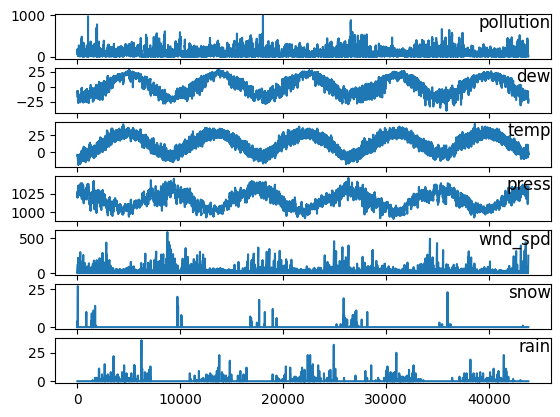

In [5]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

* Multivariate LSTM Forecast Model

    * LSTM Data Preparation

In [6]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
print(dataset)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
...                        ...  ...   ...     ...     ...      ...   ...   ...
2014-12-31 19:00:00        8.0  -23  -2.0  1034.0      NW   231.97     0     0
2014-12-31 20:00:00       10.0  -22  -3.0  1034.0      NW   237.78     0     0
2014-12-31 21:00:00       10.0  -22  -3.0  1034.0      NW   242.70     0     0
2014-12-31 22:00:00        8.0  -22  -4.0  1034.0      NW   246.72     0     0
2014-12-31 23:00:00       12.0  -21  -3.0  1034.0   

* Define and fit model.

In [7]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Epoch 1/50
122/122 - 2s - loss: 0.0659 - val_loss: 0.0537 - 2s/epoch - 13ms/step
Epoch 2/50
122/122 - 0s - loss: 0.0420 - val_loss: 0.0560 - 464ms/epoch - 4ms/step
Epoch 3/50
122/122 - 0s - loss: 0.0235 - val_loss: 0.0491 - 451ms/epoch - 4ms/step
Epoch 4/50
122/122 - 0s - loss: 0.0171 - val_loss: 0.0378 - 448ms/epoch - 4ms/step
Epoch 5/50
122/122 - 0s - loss: 0.0153 - val_loss: 0.0239 - 447ms/epoch - 4ms/step
Epoch 6/50
122/122 - 0s - loss: 0.0150 - val_loss: 0.0196 - 451ms/epoch - 4ms/step
Epoch 7/50
122/122 - 0s - loss: 0.0149 - val_loss: 0.0188 - 471ms/epoch - 4ms/step
Epoch 8/50
122/122 - 0s - loss: 0.0148 - val_loss: 0.0176 - 450ms/epoch - 4ms/step
Epoch 9/50
122/122 - 0s - loss: 0.0148 - val_loss: 0.0166 - 454ms/epoch - 4ms/step
Epoch 10/50
122/122 - 0s - loss: 0.0146 - val_loss: 0.0160 - 460ms/epoch - 4ms/step
Epoch 11/50
122/122 - 0s - loss: 0.0147 - val_loss: 0.0154 - 468ms/epoch - 4ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0152 - 515ms/epoch - 4ms/step
Epo

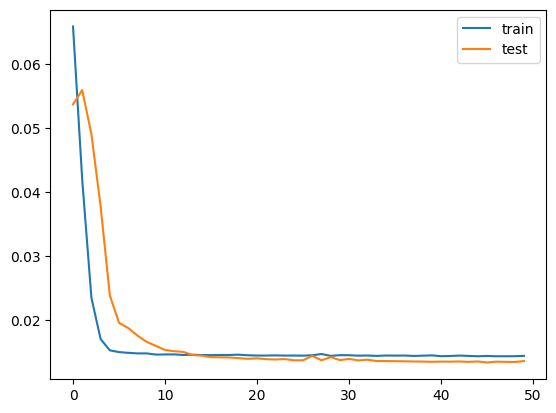

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()